# Downloader (15 min to download 2019-01-01 - Current)

In [1]:
import os

!python3 -m pip install requests
!rm -r output
!mkdir output

OUT_FILE = os.getcwd() + "/output/outfile.json"
PRETTY_OUT_FILE = os.getcwd() + "/output/pretty_outfile_small.json"

YEAR_AFTER = 2019
YEAR_BEFORE = 2021




import traceback

REQ_SIZE = 1000

import os
import json
import requests
import time
import datetime
import sys
from collections import defaultdict
from tqdm.notebook import tqdm


def YMD2utc(after_YMD: str, before_YMD: str):
    # 1. Convert YYYY-MM-DD to utc
    after_utc = datetime.datetime.strptime(after_YMD, '%Y-%m-%d')
    after_utc = time.mktime(after_utc.timetuple())
    before_utc = datetime.datetime.strptime(before_YMD, '%Y-%m-%d')
    before_utc = time.mktime(before_utc.timetuple())
    after_utc = int(after_utc)
    before_utc = int(before_utc)
#    print(after_YMD + ':' +  str(after_utc))
#    print(before_YMD + ':' + str(before_utc))
    return after_utc, before_utc


# 2: Get number of submissions within given range
# https://api.pushshift.io/reddit/submission/search/?subreddit=legaladvice&aggs=subreddit&size=0&after=2018-09-01&before=2018-10-01

def getNumSub(after_utc: int, before_utc: int):
    nd_url = "https://api.pushshift.io/reddit/submission/search/?subreddit=legaladvice&aggs=subreddit&size=0"
    nd_res = requests.get('{}&after={}&before={}'.format(nd_url, after_utc, before_utc))
    nd_data = nd_res.json() 
    nd_json = json.dumps(nd_data, indent = 4)

    numDocs = nd_data['aggs']['subreddit'][0]['doc_count']
#    print('Number of Documents:',numDocs)
    return numDocs


class StreamArray(list):
    """
    Converts a generator into a list object that can be json serialisable
    while still retaining the iterative nature of a generator.
    IE. It converts it to a list without having to exhaust the generator
    and keep it's contents in memory.
    """
    def __init__(self, generator):
        self.generator = generator
        self._len = 1

    def __iter__(self):
        self._len = 0
        for item in self.generator:
            yield item
            self._len += 1

    def __len__(self):
        """
        Json parser looks for a this method to confirm whether or not it can
        be parsed
        """
        return self._len


#Function that will iteratively generate a large set of data.
def large_list_generator_func(numDocs, after_utc, before_utc):
    global REQ_SIZE
    N = 0
    ids = []
    texts = []
    mydict = defaultdict()

    cur = after_utc
    pbar = tqdm(total=numDocs)
    while N < numDocs:
        url = "https://api.pushshift.io/reddit/search/submission/?subreddit=legaladvice&fields=id,created_utc,title,selftext"
        residue = numDocs - N;
        if residue >= 1000:
            url = "{}&size={}".format(url,REQ_SIZE)
        else:
            url = "{}&size={}".format(url,residue)

        req = requests.get("{}&after={}&before={}".format(url,cur,before_utc))
#        print('cur', cur)
#        print('before_utc', before_utc)
        try:
            r_dict = json.loads(str(req.content, "utf-8"))
        except Exception:
            traceback.print_exc()

        #print(len(r_dict["data"]))
        for doc in r_dict["data"]:
            yield doc
        chunk_size = len(r_dict["data"])
        N += chunk_size
        if chunk_size == 0:
            break
        cur = doc["created_utc"]
#        print(cur)
        pbar.update(chunk_size)
    pbar.close()



def stream_write(numDocs: int, after_utc, before_utc):
    #Write the contents to file:
    with open(OUT_FILE, "a") as outfile:
        large_generator_handle = large_list_generator_func(numDocs, after_utc, before_utc)
        stream_array = StreamArray(large_generator_handle)
        for chunk in json.JSONEncoder().iterencode(stream_array):
            if chunk != "[" and chunk != "]":
                outfile.write(chunk)
            #print("Writing chunk: ", chunk)

def main():
    yearDocs = 0
    numDocs = 0
    with open(OUT_FILE, "w") as outfile:
        outfile.write("{ \"data\": [")

    year_list = range(YEAR_AFTER, YEAR_BEFORE)
    for year in tqdm(year_list):
        print(year)
        after_ymd = str(year) + "-01-01"
        before_ymd = str(year+1) + "-01-01"

        after_utc, before_utc = YMD2utc(after_ymd, before_ymd)
        print(after_ymd)
        print(before_ymd)

        print(after_utc, before_utc)
        yearDocs = getNumSub(after_utc, before_utc)
        print(year, yearDocs)
        stream_write(yearDocs, after_utc, before_utc)
        if year != year_list[-1]:
            with open(OUT_FILE, "a") as outfile:
                outfile.write(", ")
        numDocs += yearDocs
        print(numDocs)

    with open(OUT_FILE, "a") as outfile:
        outfile.write("]}")
    with open(OUT_FILE, "r+") as f:
        data = json.load(f)
        json_object = json.dumps(data, indent=4)
    with open(PRETTY_OUT_FILE, "w") as pf:
        pf.write(json_object)
start_time = time.time()
main()
print("--- %s seconds ---" % (time.time() - start_time))
!mv output/pretty_outfile_small.json .


2019
2019-01-01
2020-01-01
1546318800 1577854800
2019 255343



255343
2020
2020-01-01
2021-01-01
1577854800 1609477200
2020 72431



327774

--- 402.61401295661926 seconds ---


# Predictor

## Load Classifier

In [2]:
import pickle
import tqdm
import sys

def loadDictFile(dictfile: str, l):    
    with open(dictfile + ".pckl", "rb") as f:
        while True:
            try:
                l.append(pickle.load(f))
            except EOFError:
                break

def loadListFile(file: str, l):    
    with open(file + ".pckl", "rb") as f:
        while True:
            try:
                l.append(pickle.load(f))
            except EOFError:
                break

def writeDictFile(file: str, l):
    with open(file + ".pckl", "wb") as f:
        for val in l.items():
            pickle.dump(val, f)
                

def writeListFile(file: str, l):
    with open(file + ".pckl", "wb") as f:
        for val in l:
            pickle.dump(val, f)


            
raw_model_list = []
raw_stat_list = []
raw_tfidf_list = []

loadDictFile("models/models_tfidf_l1", raw_model_list)
loadDictFile("stats/stats_tfidf_l1", raw_stat_list)
loadDictFile("vects/vectorizers_tfidf_l1", raw_tfidf_list)

In [3]:
from collections import defaultdict

model_dict = defaultdict()
stat_dict = defaultdict()
tfidf_dict = defaultdict()

len_ = len(raw_model_list)
for i in range(len_):
    model_dict[raw_model_list[i][0]] = raw_model_list[i][1]
    stat_dict[raw_stat_list[i][0]] = raw_stat_list[i][1]
    tfidf_dict[raw_tfidf_list[i][0]] = raw_tfidf_list[i][1]

In [4]:
class_list = []
classifier = defaultdict()

for k,v in stat_dict.items():
    if v[2] >= 0.5:
        class_list.append(k)

for cls in class_list:        
    print(cls)
#for class in class_list:
#    print("Dimension[" + cls + "]: ", len(tfidf_list[cls].vocabulary_))


BU-00-00-00-00
CO-00-00-00-00
CR-00-00-00-00
ED-00-00-00-00
ES-00-00-00-00
FA-00-00-00-00
HE-00-00-00-00
HO-00-00-00-00
HO-06-00-00-00
IM-00-00-00-00
MO-00-00-00-00
TO-00-00-00-00
TR-00-00-00-00
TR-01-00-00-00
TR-05-00-00-00
WO-00-00-00-00


## Sample Classification

In [5]:
import numpy as np

text = "I had my car parked at work and someone stole my car. I went to report my car stolen at the police station but I got a call later saying I can’t report it stolen because a title change occurred. I never sold my car, never signed anything. I feel completely powerless and violated. I honestly don’t know what to do. If I find out who stole my car I will most likely snap because I don’t know what else to do. This has never happened to me. What legal steps can I take?"

#text = "My landlord has been stealing my oil for almost 2 years I live in MA. I rent an in-law style apartment where my landlord lives in the main big house (by herself) and I live in the (only connected by a breezeway, but all under the same roof technically) in-law side (also by myself). My lease states that all utilities for the in-law apartment are to be paid by the tenant and that the apartment has its own separate meters & oil tank. I verified before moving in that it is in fact a legal apartment with separate meters and 2 separate oil tanks (or so I thought). The oil tanks are in my landlords basement, which I do not have personal access to. I’ve requested before to see them (for unrelated issues - mainly to be able to check the oil level), but there is always an excuse as to why I can’t. Anyway, I’ve lived here for almost 2 years and at first, I didn’t really notice if I was going through oil fast or not (never had it before, so wasn’t sure what the norm was). But recently, I’ve been noticing that I’ve been going through 100 gallons every month for the past 3-4 months (I’m on automatic delivery and the company can tell when it gets low I guess and they automatically show up and then bill me). I finally called to try and figure out why I’m going through it so much, and they didn’t really know what to tell me. Today was how I found out. I woke up to no heat and no hot water (they both run off of my oil). I was confused but it was too early to call the oil company (they weren’t open yet) so I waited it out. My phone rang and my landlord asked me if I had run out of oil, because HER WATER WAS COLD. It didn’t even dawn on me what she was saying when she said it. However, I called the oil company, they came out, and had to prime my tank and gave me another 100 gallons. I asked the tech if it was normal for my landlord to not have hot water when MY tank ran out of oil, seeing as how we have separate tanks and I didn’t understand why my tank had anything to do with her water. The tech confirmed that my tank shouldn’t have anything to do with her water as were completely separate. I advised my landlord that it seems as though the oil I pay for is going towards her hot water (and most likely heat as well), and she immediately got defensive and said “well I guess that’s just how the house was built” and closed the door on me. I can’t imagine this is legal, especially with a lease, and it being rented as completely separate utilities. I’ve clearly been paying for her heat and hot water for almost 2 years and now I’m pissed at her response when I tried to ask her about it.Do I have any legal grounds?Thank you"
print(text)

predictions = defaultdict() 
prob = defaultdict()

for cls in class_list:
    text_tfidf = tfidf_dict[cls].transform([text])
    predictions[cls] = model_dict[cls].predict(text_tfidf)
    prob[cls] = model_dict[cls].predict_proba(text_tfidf)[:,1]

for k,v in predictions.items():   
    if v > 0:
        print(k, v, end = ' ')
        print(np.round(prob[k], 4))

I had my car parked at work and someone stole my car. I went to report my car stolen at the police station but I got a call later saying I can’t report it stolen because a title change occurred. I never sold my car, never signed anything. I feel completely powerless and violated. I honestly don’t know what to do. If I find out who stole my car I will most likely snap because I don’t know what else to do. This has never happened to me. What legal steps can I take?
CR-00-00-00-00 [1.] [1.]
MO-00-00-00-00 [1.] [0.9899]
TO-00-00-00-00 [1.] [0.9765]
TR-00-00-00-00 [1.] [1.]
TR-05-00-00-00 [1.] [0.8779]


## Load JSON

In [6]:
import json
import os

JSON_PATH = os.getcwd() + "/pretty_outfile_small.json"

def loadJSON():
    with open(JSON_PATH, "r") as f:
        json_object = json.load(f)
    return json_object

json_object = loadJSON()
docs = json_object['data']

print(len(docs))
print()
print(docs[-1])

327771

{'created_utc': 1586369829, 'id': 'fxbn49', 'selftext': 'Hello /r/legaladvice, I received a call this morning from a few towns over. When I answered I was greeted with my name so I asked who I was talking to and they introduced themselves as a detective and gave their name but I promptly forgot it. They asked if I knew someone (they gave a name) and I didn\'t recognize it so I said no and began to be puzzled as for the reason of the call. He asked if I remember talking on the phone with them and suggested I knew her from a dating app. I have tinder but don\'t usually get numbers from it, and no one I\'ve spoken to from there that I\'m currently matched with matched the name he gave me. I conceded this and asked why, hoping he\'d let me know why/what he was investigating. He just double checked that I don\'t remember calling her and said he "knew I had spoken with her". After this he asked if he could come and meet me (like he knew where I lived) within the week and I said sure 

## Utility Functions

In [7]:
import sys
import datetime as dt
import time
from collections import defaultdict
import pandas as pd
import pylab as pl

def utc2ymd(utc: str) -> str:
    return dt.datetime.utcfromtimestamp(utc).strftime("%Y-%m-%d")

def utc2y(utc: str) -> str:
    return dt.datetime.utcfromtimestamp(utc).strftime("%Y")

def utc2m(utc: str) -> str:
    return dt.datetime.utcfromtimestamp(utc).strftime("%Y-%m")

def utc2w(utc: str) -> str:
    ymd = dt.datetime.utcfromtimestamp(utc).strftime("%Y-%m-%d")
    year = int(ymd[0:4])
    month = int(ymd[5:7])
    day = int(ymd[8:10])
    wknumber = dt.date(year, month, day).isocalendar()[1]
    return str(year) + "-W" + str(wknumber)



def utc2d(utc: str) -> str:
    #return dt.datetime.utcfromtimestamp(utc).strftime("%Y/%m/%d %H:%M")
    return dt.datetime.utcfromtimestamp(utc).strftime("%Y-%m-%d")

def ymd2utc(ymd: str) -> int:
    utc = dt.datetime.strptime(ymd, '%Y-%m-%d')
    utc = time.mktime(utc.timetuple())
    utc = int(utc)
    return utc

def datetime2utc(dt) -> int:
    utc = time.mktime(dt.timetuple())
    utc = int(utc)
    return utc
    

def ymd2week(y: int, m: int, d: int) -> int:
    dt = datetime.date(y, m, d) 
    wk = dt.isocalendar()[1]



def pretty(d, indent=0):
    print('------------------------------------')
    print('id: ', d['id'])
    ymd = utc2ymd(d['created_utc'])
    print('created_utc:', d['created_utc'], ymd)
    print('title:', d['title'])
    print('selftext:', d['selftext'])
    print('\n')
    print('------------------------------------')
    
for doc in docs:
    doc["ymd"] = utc2ymd(doc["created_utc"])
    doc["year"] = utc2y(doc["created_utc"])
    doc["month"] = utc2m(doc["created_utc"])
    doc["week"] = utc2w(doc["created_utc"])
    doc["day"] = utc2d(doc["created_utc"])

/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


## Annual Submissions

In [8]:
annual_dict = {}
num_docs = {}

for year in range(2010, 2020):
    ymd_after = str(year) + '-01-01'
    ymd_before = str(year+1) + '-01-01'
    utc_after = ymd2utc(ymd_after)
    utc_before = ymd2utc(ymd_before)
    annual_dict[str(year)] = (utc_after, utc_before)

print(annual_dict)


for doc in docs:
    for k,v in annual_dict.items():
        if v[0] <= doc['created_utc'] < v[1]:
            if k in num_docs:
                num_docs[k] += 1
            else:
                num_docs[k] = 1

{'2010': (1262322000, 1293858000), '2011': (1293858000, 1325394000), '2012': (1325394000, 1357016400), '2013': (1357016400, 1388552400), '2014': (1388552400, 1420088400), '2015': (1420088400, 1451624400), '2016': (1451624400, 1483246800), '2017': (1483246800, 1514782800), '2018': (1514782800, 1546318800), '2019': (1546318800, 1577854800)}


## Monthly Submissions

In [9]:
monthly_dict = {}
monthly_num_docs = {}

month_arr = ["01","02","03","04","05","06","07","08","09","10","11","12"]

last_utc = ymd2utc("2020-04-01")

for year in range(2019, 2021):
    for i in range(len(month_arr)):
        ymd_after = str(year) + "-" + month_arr[i] + "-01"
        if i == 11:
            ymd_before = str(year+1) + "-01-01"            
        else:
            ymd_before = str(year) + "-" + month_arr[i+1] + "-01"
            
        utc_after = ymd2utc(ymd_after)
        utc_before = ymd2utc(ymd_before)
        
        if utc_before > last_utc: 
            break
            
        monthly_dict[str(year) + "-" + month_arr[i]] = (utc_after, utc_before)

for doc in docs:
    for k,v in monthly_dict.items():
        if v[0] <= doc['created_utc'] < v[1]:

            if k in monthly_num_docs:
                monthly_num_docs[k] += 1
            else:
                monthly_num_docs[k] = 1

In [10]:
print(monthly_num_docs)

{'2019-01': 21471, '2019-02': 20206, '2019-03': 22103, '2019-04': 21334, '2019-05': 22326, '2019-06': 21561, '2019-07': 23165, '2019-08': 22826, '2019-09': 21235, '2019-10': 20484, '2019-11': 18790, '2019-12': 19839, '2020-01': 22615, '2020-02': 21147, '2020-03': 23253}


## Weekly Submissions

In [11]:
weekly_dict = {}
weekly_num_docs = {}

for year in range(2020, 2021):
    for week in range(1,53):
        yw_after = str(year) + "-W" + str(week)
        ymd_after = dt.datetime.strptime(yw_after + '-1', "%G-W%V-%u").date()

        yw_before = str(year) + "-W" + str(week+1)
        ymd_before = dt.datetime.strptime(yw_before + '-1', "%G-W%V-%u").date()
    
        utc_after = datetime2utc(ymd_after)
        utc_before = datetime2utc(ymd_before)

        weekly_dict[yw_after] = (utc_after, utc_before)

print(weekly_dict)

for doc in docs:
    for k,v in weekly_dict.items():
        if v[0] <= doc['created_utc'] < v[1]:
            if k in weekly_num_docs:
                weekly_num_docs[k] += 1
            else:
                weekly_num_docs[k] = 1

{'2020-W1': (1577682000, 1578286800), '2020-W2': (1578286800, 1578891600), '2020-W3': (1578891600, 1579496400), '2020-W4': (1579496400, 1580101200), '2020-W5': (1580101200, 1580706000), '2020-W6': (1580706000, 1581310800), '2020-W7': (1581310800, 1581915600), '2020-W8': (1581915600, 1582520400), '2020-W9': (1582520400, 1583125200), '2020-W10': (1583125200, 1583726400), '2020-W11': (1583726400, 1584331200), '2020-W12': (1584331200, 1584936000), '2020-W13': (1584936000, 1585540800), '2020-W14': (1585540800, 1586145600), '2020-W15': (1586145600, 1586750400), '2020-W16': (1586750400, 1587355200), '2020-W17': (1587355200, 1587960000), '2020-W18': (1587960000, 1588564800), '2020-W19': (1588564800, 1589169600), '2020-W20': (1589169600, 1589774400), '2020-W21': (1589774400, 1590379200), '2020-W22': (1590379200, 1590984000), '2020-W23': (1590984000, 1591588800), '2020-W24': (1591588800, 1592193600), '2020-W25': (1592193600, 1592798400), '2020-W26': (1592798400, 1593403200), '2020-W27': (1593403

In [12]:
print(weekly_num_docs)

{'2020-W1': 4474, '2020-W2': 5296, '2020-W3': 5137, '2020-W4': 5013, '2020-W5': 5064, '2020-W6': 5142, '2020-W7': 5265, '2020-W8': 5085, '2020-W9': 5139, '2020-W10': 5104, '2020-W11': 5164, '2020-W12': 5380, '2020-W13': 5367, '2020-W14': 5224, '2020-W15': 1857}


## Daily Submissions

In [13]:
daily_dict = {}
daily_num_docs = {}


i2lenTwo = lambda i: "0" + str(i) if len(str(i)) == 1 else str(i)

for year in range(2020, 2021):
    for i in range(2,4): #Feb - March
        if i in [1,3,5,7,8,10,12]:
            last_day = 31
        elif i in [4,6,9,11]:
            last_day = 30
        elif year % 4 == 0:
            last_day = 29
        else:
            last_day = 28
            
        for j in range(1, last_day+1):
            ymd_after = str(year) + "-" + i2lenTwo(i) + "-" + i2lenTwo(j)
            if j == last_day:
                if i == 11:
                    ymd_before = str(year+1) + "-01-01"
                else:
                    ymd_before = str(year) + "-" + i2lenTwo(i+1) + "-" + "01"
            else:
                ymd_before = str(year) + "-" + i2lenTwo(i) + "-" + i2lenTwo(j+1)
            
#            print(ymd_after, ymd_before)
            
            utc_after = ymd2utc(ymd_after)
            utc_before = ymd2utc(ymd_before)
            daily_dict[str(year) + "-" + i2lenTwo(i) + "-" + i2lenTwo(j)] = (utc_after, utc_before)


            
for doc in docs:
    for k,v in daily_dict.items():
        if v[0] <= doc['created_utc'] < v[1]:
            if k in daily_num_docs:
                daily_num_docs[k] += 1
            else:
                daily_num_docs[k] = 1

print(docs[0])


{'created_utc': 1546319086, 'id': 'abf6yi', 'selftext': 'I\'m not even sure where to begin here, i responded to an ad on [indeed.com](https://indeed.com) where someone was looking for an "MTG Expert".  We emailed back and forth and he asked me to come in for an interview, it was fairly short notice, but he insisted he was in a hurry to get this started ASAP, so i ended up spending over $700 to fly out and stay in Chicago for 3 days during the interview.  For me $700 is a LOT of money, i barely make $1000 a month, so i basically used 3/4th months pay for this.\n\n&amp;#x200B;\n\nThe interview went well, he seemed happy with me and my responses to his questions, and I went home feeling good.  I didn\'t hear back from him for several days, after a week of waiting i sent him an email just to inquire about the job and he replied with more questions about how to run an LGS, and implied, but didn\'t say outright, that he wanted me to run the place for him.  I sent him several more emails with

In [14]:
print(daily_num_docs)

{'2020-02-01': 545, '2020-02-02': 544, '2020-02-03': 787, '2020-02-04': 901, '2020-02-05': 796, '2020-02-06': 806, '2020-02-07': 727, '2020-02-08': 533, '2020-02-09': 592, '2020-02-10': 836, '2020-02-11': 879, '2020-02-12': 822, '2020-02-13': 848, '2020-02-14': 680, '2020-02-15': 630, '2020-02-16': 570, '2020-02-17': 766, '2020-02-18': 892, '2020-02-19': 789, '2020-02-20': 745, '2020-02-21': 752, '2020-02-22': 584, '2020-02-23': 557, '2020-02-24': 817, '2020-02-25': 816, '2020-02-26': 821, '2020-02-27': 819, '2020-02-28': 675, '2020-02-29': 618, '2020-03-01': 573, '2020-03-02': 792, '2020-03-03': 832, '2020-03-04': 835, '2020-03-05': 768, '2020-03-06': 735, '2020-03-07': 602, '2020-03-08': 540, '2020-03-09': 758, '2020-03-10': 860, '2020-03-11': 832, '2020-03-12': 788, '2020-03-13': 695, '2020-03-14': 627, '2020-03-15': 604, '2020-03-16': 843, '2020-03-17': 850, '2020-03-18': 839, '2020-03-19': 819, '2020-03-20': 824, '2020-03-21': 634, '2020-03-22': 571, '2020-03-23': 813, '2020-03-24

## Plotting

In [15]:
import matplotlib, matplotlib.pyplot as plt
import pandas as pd
matplotlib.style.use("ggplot")
#plt.xkcd()
plt.rcdefaults()
plt.figure()

def plotDictBar(d: dict, degree:int):
    d.pop("2010", None)
    xdata = []
    ydata = []
    for k,v in d.items():
        xdata.append(k)
        ydata.append(v)
    xdata = np.asarray(xdata)
    ydata = np.asarray(ydata)
    plt.bar(xdata, ydata)
    plt.xticks(rotation=degree)




#    plt.annotate(s="Peak", xy=(ydata.argmax(), ydata.max()),\
#                 xytext=(ydata.argmax()+0.01, ydata.max()+0.01),\
#                 arrowprops={"facecolor":"black", "shrink":0.2})
#    plt.ylabel("Number of Submissions")


<Figure size 640x480 with 0 Axes>

In [16]:
import matplotlib, matplotlib.pyplot as plt
import pandas as pd
matplotlib.style.use("ggplot")
#plt.xkcd()
plt.rcdefaults()
plt.figure()
def plotDict(d: dict, degree:int, marker:str):
    plt.xticks(rotation=degree)
    d.pop("2010", None)
    xdata = []
    ydata = []
    for k,v in d.items():
        xdata.append(k)
        ydata.append(v)
    xdata = np.asarray(xdata)
    ydata = np.asarray(ydata)

    plt.plot(xdata, ydata, marker)

#    plt.annotate(s="Peak", xy=(ydata.argmax(), ydata.max()),\
#                 xytext=(ydata.argmax()+0.01, ydata.max()+0.01),\
#                 arrowprops={"facecolor":"black", "shrink":0.2})
#    plt.ylabel("Number of Submissions")


<Figure size 640x480 with 0 Axes>

In [17]:
#plotDictBar(num_docs,0)

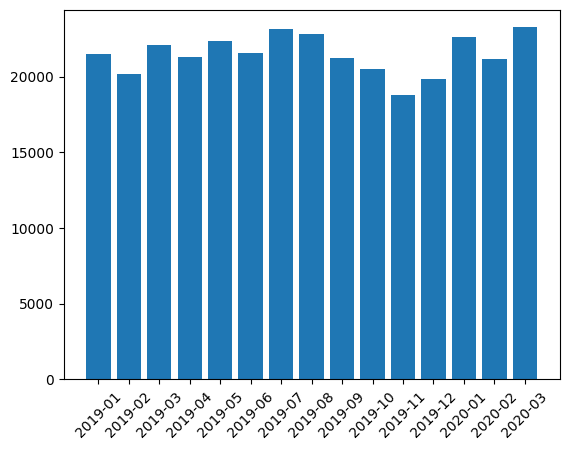

In [18]:
plotDictBar(monthly_num_docs,45)

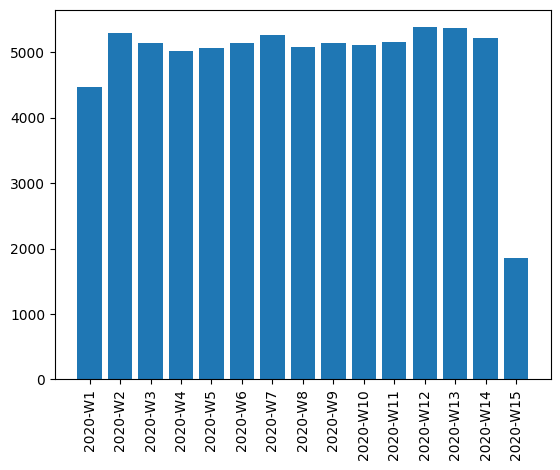

In [19]:
plotDictBar(weekly_num_docs, 90)

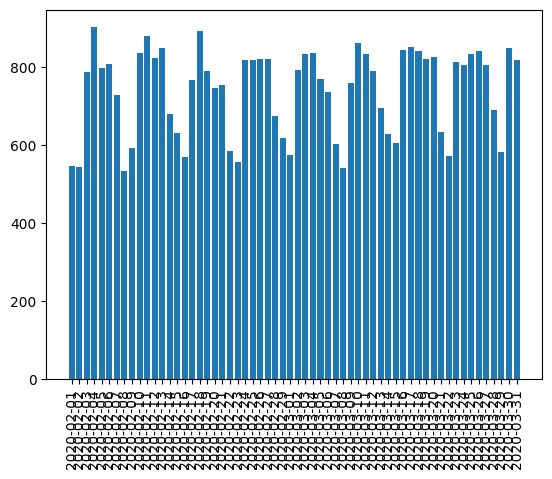

In [20]:
plotDictBar(daily_num_docs,90)

## Prediction (Takes about 40 min for 1G data)
* Remove comment and run it if you have new data

In [21]:

import time
from collections import Counter
from tqdm.notebook import tqdm
import multiprocessing
from joblib import Parallel, delayed

def prediction():

    start_time = time.time()

    def mytransform(cls):
        X_tfidf = tfidf_dict[cls].transform(X)
        return X_tfidf

    def generateLabels(cls, X_tfidf):
        hard_v = model_dict[cls].predict(X_tfidf)
        soft_v = model_dict[cls].predict_proba(X_tfidf)[:,1]
        print(cls + ": ")

        print("Hard Labels: ", hard_v)
        print("Soft Lables: ", soft_v)
        print()
        return (hard_v, soft_v)

    #class_list = ["TR-00-00-00-00"]
    X = []
    for doc in docs:
        text = ""
        if 'title' in doc.keys():
            text += doc['title'] + " "
        if 'selftext' in doc.keys():
            text += doc['selftext']
        X.append(text)

    for cls in tqdm(class_list):
        X_tfidf = mytransform(cls)
        hard_v, soft_v = generateLabels(cls, X_tfidf)
        writeListFile("prevs/" + cls[:5], (hard_v, soft_v))

    print("--- %s seconds ---" % (time.time() - start_time))
prediction()

BU-00-00-00-00: 
Hard Labels:  [0. 0. 0. ... 0. 0. 0.]
Soft Lables:  [0.00924565 0.00293575 0.18762772 ... 0.00685043 0.00614282 0.01196964]

CO-00-00-00-00: 
Hard Labels:  [0. 0. 0. ... 0. 0. 0.]
Soft Lables:  [0.01108526 0.09135641 0.07260569 ... 0.00621588 0.02874977 0.10542214]

CR-00-00-00-00: 
Hard Labels:  [0. 0. 0. ... 0. 0. 0.]
Soft Lables:  [0.08852589 0.34918469 0.08854974 ... 0.00241468 0.00199153 0.22908057]

ED-00-00-00-00: 
Hard Labels:  [0. 0. 0. ... 0. 0. 0.]
Soft Lables:  [0.00433665 0.00433665 0.0055075  ... 0.00433665 0.00433665 0.00602645]

ES-00-00-00-00: 
Hard Labels:  [0. 0. 0. ... 0. 0. 0.]
Soft Lables:  [0.00251758 0.00514824 0.00683354 ... 0.00354794 0.00170381 0.00595467]

FA-00-00-00-00: 
Hard Labels:  [0. 0. 0. ... 0. 0. 0.]
Soft Lables:  [0.00859389 0.03052386 0.16100589 ... 0.01824852 0.07276082 0.01802796]

HE-00-00-00-00: 
Hard Labels:  [0. 0. 0. ... 0. 0. 0.]
Soft Lables:  [0.00879936 0.00416583 0.00267973 ... 0.00331797 0.01037128 0.01032467]

HO-00-

## Load hard and soft labels

In [22]:
from collections import defaultdict
from tqdm.notebook import tqdm



def CC(hard_v):
    num_pos = Counter()
    cc = defaultdict() # year-prevalenc©e
    for i in range(len(docs)):
        if hard_v[i] == 1:
            num_pos[docs[i]["year"]] += 1
    for k in num_docs.keys():
        cc[k] = num_pos[k] / num_docs[k]
    return cc


def PCC(soft_v):
    sum_prob = defaultdict()
    pcc = defaultdict() # year-prevalence
    for i in range(len(docs)):
        yr = docs[i]["year"]
        if yr in sum_prob.keys():
            sum_prob[yr] += soft_v[i]
        else:
            sum_prob[yr] = soft_v[i]
    for k in num_docs.keys():
        pcc[k] = sum_prob[k] / num_docs[k]
    return pcc
    
    


hard_dict = defaultdict()
soft_dict = defaultdict()


for cls in tqdm(class_list):
    label_list = []
    loadListFile("prevs/" + cls[:5], label_list)
    hard_dict[cls] = label_list[0]
    soft_dict[cls] = label_list[1]
    
print(hard_dict)


defaultdict(None, {'BU-00-00-00-00': array([0., 0., 0., ..., 0., 0., 0.]), 'CO-00-00-00-00': array([0., 0., 0., ..., 0., 0., 0.]), 'CR-00-00-00-00': array([0., 0., 0., ..., 0., 0., 0.]), 'ED-00-00-00-00': array([0., 0., 0., ..., 0., 0., 0.]), 'ES-00-00-00-00': array([0., 0., 0., ..., 0., 0., 0.]), 'FA-00-00-00-00': array([0., 0., 0., ..., 0., 0., 0.]), 'HE-00-00-00-00': array([0., 0., 0., ..., 0., 0., 0.]), 'HO-00-00-00-00': array([0., 0., 0., ..., 0., 1., 0.]), 'HO-06-00-00-00': array([0., 0., 0., ..., 0., 1., 0.]), 'IM-00-00-00-00': array([0., 0., 0., ..., 0., 0., 0.]), 'MO-00-00-00-00': array([1., 1., 1., ..., 0., 0., 0.]), 'TO-00-00-00-00': array([0., 0., 0., ..., 0., 0., 0.]), 'TR-00-00-00-00': array([0., 0., 0., ..., 0., 0., 0.]), 'TR-01-00-00-00': array([0., 0., 0., ..., 0., 0., 0.]), 'TR-05-00-00-00': array([0., 0., 0., ..., 0., 0., 0.]), 'WO-00-00-00-00': array([1., 0., 1., ..., 1., 0., 0.])})


## Calculate Label Prior from Training Data(Legal Hands)

In [23]:
from sklearn.model_selection import KFold
import pandas as pd
import numpy as np
verbose = False
def preprocessing(dfset: defaultdict, cls: str):
    dfset[cls] = df.loc[:, ['_id', 'full_text', cls]]
    labels = dfset[cls].iloc[:,2]
    if verbose:
        print("------------Before dropping nan----------------------------------------")
        print(dfset[cls].iloc[:,1:])
        print(labels.value_counts(dropna=False))
    
    dfset[cls] = dfset[cls].dropna()
    labels = dfset[cls].iloc[:,2]
    if verbose:
        print("\n------------After dropping nan---------------------------------------")
        print(dfset[cls].iloc[:,1:])
        print(labels.value_counts(dropna=False))

'''
def predict_train(dfset: defaultdict, cls: str):  
    
    tinydf = dfset[cls]
    X = tinydf['full_text'].values
    Y = tinydf[cls].values

    labels = dfset[cls].iloc[:,2]
    print(labels.value_counts(dropna=False))

    kfold = KFold(n_splits=10)
    print('data set size', len(X))
    numdoc[cls] = len(X)
    n_iter = 0
    preds = [0] * len(Y)

    for train_index, test_index in kfold.split(X, Y):
        X_train, X_test = X[train_index], X[test_index] 
        Y_train, Y_test = Y[train_index], Y[test_index] 

        X_train_tfidf = tfidf_dict[cls].transform(X_train)
        X_test_tfidf = tfidf_dict[cls].transform(X_test)

        out = model_dict[cls].predict(X_test_tfidf)
#        prob = model.predict_proba(X_test_tfidf)[:,1]
        i = 0
        for x in test_index:
            preds[x] = out[i]
            i += 1
        n_iter += 1
    return preds
'''

url = 'https://raw.githubusercontent.com/heeh/legal_issue_classification/master/2019-12-06_95p-confidence_binary.csv'
df = pd.read_csv(url)
df.info()
df.iloc[:,:4]
df = df.loc[:, df.sum(axis=0, skipna=True) != 0]
temp = df.sum(axis = 0, skipna = True)
oldCols = list(df.columns)
newCols = []
for i,x in temp[2:].items():
    if x >= 10:
        newCols.append(i)        
cols = oldCols[:2] + newCols
df = df[cols]
df.sum(axis=0, skipna=True)


dfset = defaultdict()
label_prior = defaultdict()
y_train = defaultdict()
numdoc = defaultdict()

for cls in tqdm(class_list):
    preprocessing(dfset, cls)
    #y_train[cls] = predict_train(dfset, cls)
    tinydf = dfset[cls]
    y_train[cls] = tinydf[cls].values
    label_prior[cls] = np.mean(y_train[cls])
    print(cls + ": " + str(np.round(label_prior[cls], 4)))
    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2777 entries, 0 to 2776
Columns: 109 entries, _id to WO-09-00-00-00
dtypes: float64(107), object(2)
memory usage: 2.3+ MB


BU-00-00-00-00: 0.0585
CO-00-00-00-00: 0.0911
CR-00-00-00-00: 0.1799
ED-00-00-00-00: 0.0132
ES-00-00-00-00: 0.0401
FA-00-00-00-00: 0.1748
HE-00-00-00-00: 0.0642
HO-00-00-00-00: 0.258
HO-06-00-00-00: 0.0205
IM-00-00-00-00: 0.0183
MO-00-00-00-00: 0.2561
TO-00-00-00-00: 0.183
TR-00-00-00-00: 0.1296
TR-01-00-00-00: 0.012
TR-05-00-00-00: 0.0171
WO-00-00-00-00: 0.1944



## Print Samples

In [24]:
!pip3 install isoweek
from isoweek import Week
CLIST = ["WO-00-00-00-00"]
#CLIST = class_list
YR = 2020
WK = range(1,15)
MAX_DOC = 5


def printSample(class_list, yr, wk_list, maxdoc):
    for wk in wk_list:
        for cls in class_list:
            d_begin = Week(yr, wk).monday().strftime("%Y-%m-%d")
            d_end = Week(yr, wk+1).monday().strftime("%Y-%m-%d")
            print("-------------------------------------------------------------------------------------------------")
            print(cls + ": " + str(yr) + "-W" + str(wk) + " (" + d_begin + " ~ " + d_end + ")")

            print("-------------------------------------------------------------------------------------------------")
            num = 1
            for i in range(len(docs)):
                if num > maxdoc:
                    break
                week_id = str(yr) + "-W" + str(wk)
                if docs[i]["week"] == week_id and hard_dict[cls][i] == 1 and "pandemic" in docs[i]["title"]:
                    print(str(num) + ": " + docs[i]["title"])
                    num += 1

printSample(CLIST, YR, WK, MAX_DOC)

-------------------------------------------------------------------------------------------------
WO-00-00-00-00: 2020-W1 (2019-12-30 ~ 2020-01-06)
-------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------
WO-00-00-00-00: 2020-W2 (2020-01-06 ~ 2020-01-13)
-------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------
WO-00-00-00-00: 2020-W3 (2020-01-13 ~ 2020-01-20)
-------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------
WO-00-00-00-00: 2020-W4 (2020-01-20 ~ 2020-01-27)
-------------------------------------------------------------------------------------------------
----------------

In [25]:
CLIST = ["HO-00-00-00-00"]
#CLIST = class_list
YR = 2020
WK = range(1,15)
MAX_DOC = 10

printSample(CLIST, YR, WK, MAX_DOC)

-------------------------------------------------------------------------------------------------
HO-00-00-00-00: 2020-W1 (2019-12-30 ~ 2020-01-06)
-------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------
HO-00-00-00-00: 2020-W2 (2020-01-06 ~ 2020-01-13)
-------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------
HO-00-00-00-00: 2020-W3 (2020-01-13 ~ 2020-01-20)
-------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------
HO-00-00-00-00: 2020-W4 (2020-01-20 ~ 2020-01-27)
-------------------------------------------------------------------------------------------------
----------------

## Freq-e(Annual)

In [26]:
import freq_e

def FREQ_E(soft_dict, label_prior):
    bucket = defaultdict()
    freq_dict = defaultdict()
    
    for i in range(len(docs)):
        yr = docs[i]["year"]
        if yr in bucket.keys():
            bucket[yr].append(soft_dict[i])
        else:
            bucket[yr] = [soft_dict[i]]
            
    for k in num_docs.keys():
        test_pred_probs = np.asarray(bucket[k])
        out = freq_e.infer_freq_from_predictions(test_pred_probs, label_prior)
        freq_dict[k] = out["point"]

    return freq_dict

## Label Prior Question: Why goes down?

[0.00171246 0.00157591 0.00135553 ... 0.00166577 0.00228152 0.00826145]
0.1296111665004985


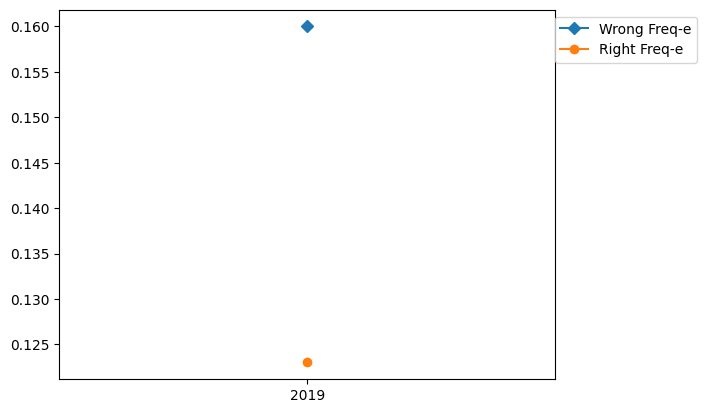

In [27]:
from collections import Counter
test_cls = "TR-00-00-00-00"
print(soft_dict[test_cls])
print(label_prior[test_cls])


cc = CC(hard_dict[test_cls])
pcc = PCC(soft_dict[test_cls])
freq_e_wrong = FREQ_E(soft_dict[test_cls], label_prior[test_cls])
freq_e_right = FREQ_E(soft_dict[test_cls], 0.5)

plotDict(freq_e_wrong, 0, "-D")
plotDict(freq_e_right, 0, "-o")


plt.legend(["Wrong Freq-e", "Right Freq-e"], bbox_to_anchor=(1.3, 1), loc='upper right', ncol=1)
#plt.legend(class_list,loc=1, prop={'size': 6})
plt.show()

## CC, PCC, and Freq-e

[0.00171246 0.00157591 0.00135553 ... 0.00166577 0.00228152 0.00826145]
0.1296111665004985


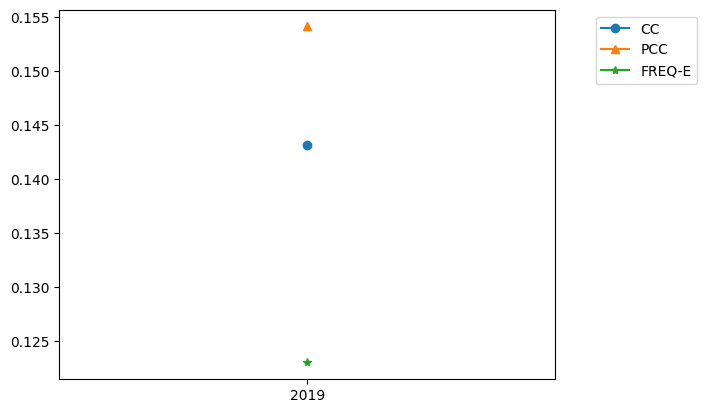

In [28]:
from collections import Counter
test_cls = "TR-00-00-00-00"
print(soft_dict[test_cls])
print(label_prior[test_cls])


cc = CC(hard_dict[test_cls])
pcc = PCC(soft_dict[test_cls])
freq_e_result = FREQ_E(soft_dict[test_cls], 0.5)

plotDict(cc, 0, "-o")
plotDict(pcc, 0, "-^")
plotDict(freq_e_result, 0, "-*")

plt.legend(["CC", "PCC", "FREQ-E"], bbox_to_anchor=(1.3, 1), loc='upper right', ncol=1)
#plt.legend(class_list,loc=1, prop={'size': 6})
plt.show()

## Annual Prevalence(2011/1/1 - 2019/12/31)

In [29]:
def plot_prev(filename, class_list):
    m_list = ["-o", "-s", "-^"]
    i = 0
    for cls in tqdm(class_list[:7]):
        label_list = []
        loadListFile("prevs/" + cls[:5], label_list)
        hard_dict[cls] = label_list[0]
        soft_dict[cls] = label_list[1]
        #cc = CC(hard_dict[cls])
        result = FREQ_E(soft_dict[cls], 0.5)
        marker = m_list[i//7]
        plotDict(result, 0, marker)
        i += 1
    lgd = plt.legend(class_list, bbox_to_anchor=(1.6, 1), loc='upper right', ncol=1)
    plt.savefig("figs/" + filename, bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.show()

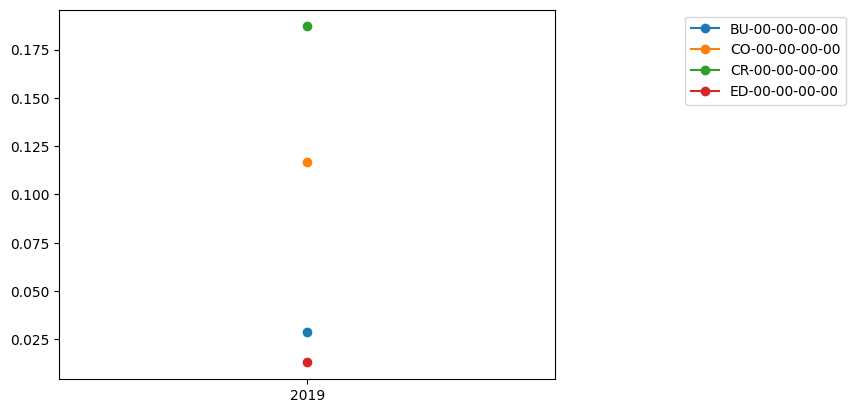

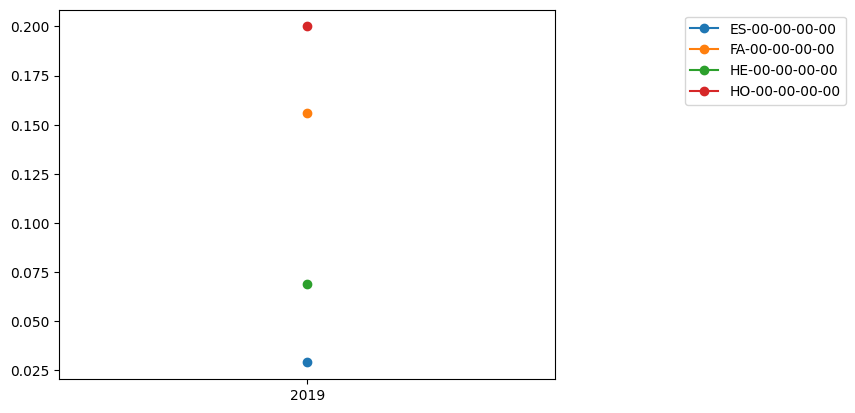

In [30]:
for i in tqdm([0,1]):
    plot_prev('annual_1.png', class_list[4*i:4*i+4])

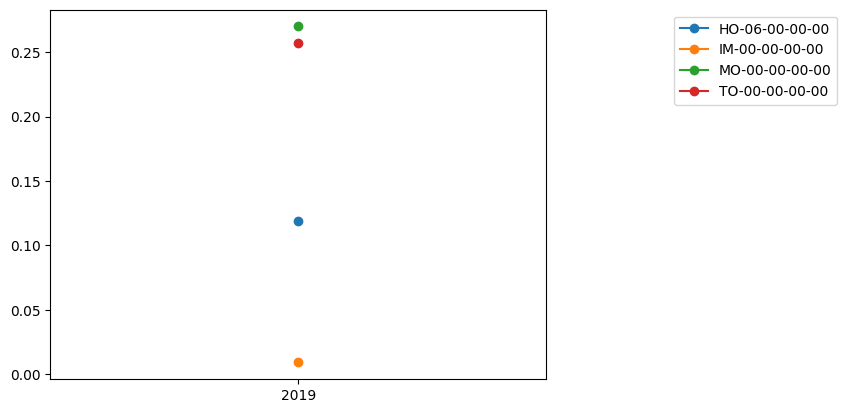

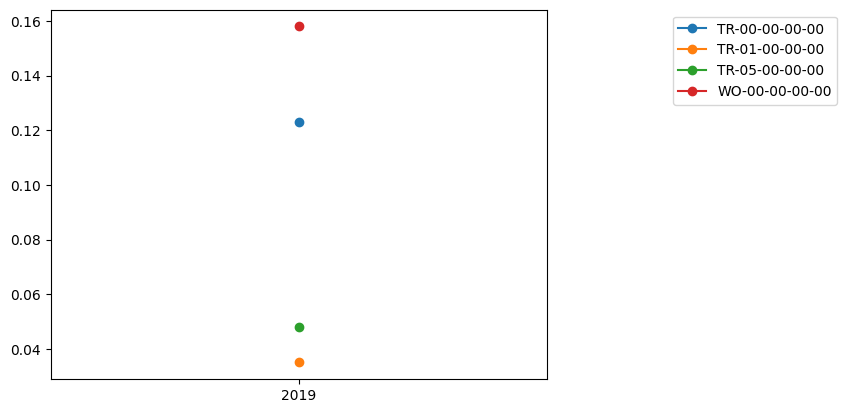

In [31]:
for i in tqdm([2,3]):
    plot_prev("annual_2.png",class_list[4*i:4*i+4])

## Monthly Prevalence(2019/01/31-2020/03/29)

In [32]:
import freq_e

def FREQ_E_MONTHLY(soft_dict, label_prior):
    bucket = defaultdict()
    freq_dict = defaultdict()
    
    for i in range(len(docs)):
        mt = docs[i]["month"]
        if mt in bucket.keys():
            bucket[mt].append(soft_dict[i])
        else:
            bucket[mt] = [soft_dict[i]]
            
    # We collect keys only in monthly_num_docs
    for k in monthly_num_docs.keys():
        test_pred_probs = np.asarray(bucket[k])
        out = freq_e.infer_freq_from_predictions(test_pred_probs, label_prior)
        freq_dict[k] = out["point"]

    return freq_dict

def plot_prev_monthly(filename, class_list):
    plt.gcf().subplots_adjust(bottom=0.15)
    for cls in tqdm(class_list[:7]):
        label_list = []
        loadListFile("prevs/" + cls[:5], label_list)
        hard_dict[cls] = label_list[0]
        soft_dict[cls] = label_list[1]
        #cc = CC(hard_dict[cls])
        result = FREQ_E_MONTHLY(soft_dict[cls], 0.5)
        plotDict(result, 45, "-s")
    lgd = plt.legend(class_list, bbox_to_anchor=(1.6, 1), loc='upper right', ncol=1)
    plt.savefig("figs/" + filename, bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.show()

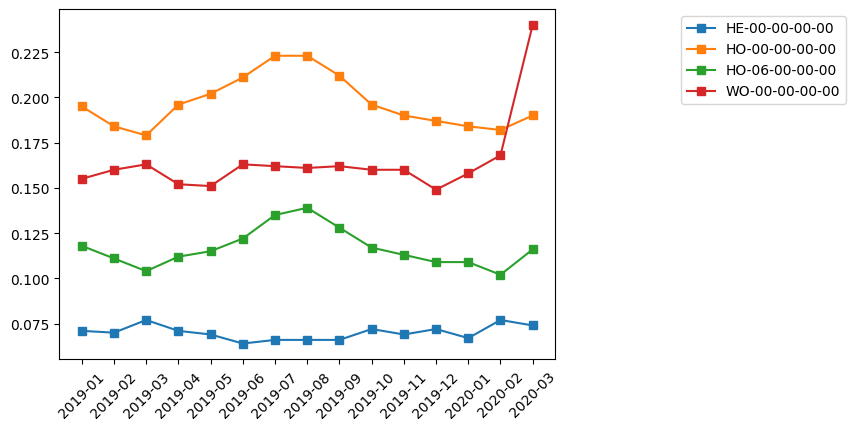

In [33]:
plot_prev_monthly('monthly_1.png', ["HE-00-00-00-00","HO-00-00-00-00","HO-06-00-00-00","WO-00-00-00-00"])

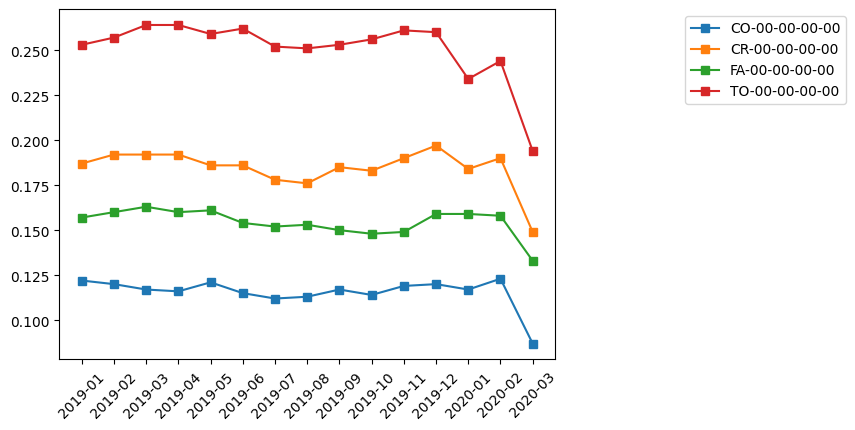

In [34]:
plot_prev_monthly("monthly_2.png", ["CO-00-00-00-00","CR-00-00-00-00","FA-00-00-00-00","TO-00-00-00-00"])

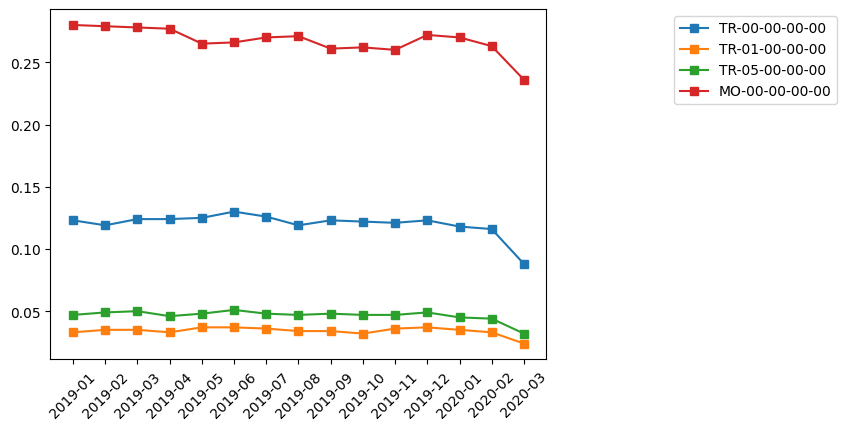

In [35]:
plot_prev_monthly('monthly_3.png', ["TR-00-00-00-00","TR-01-00-00-00","TR-05-00-00-00","MO-00-00-00-00"])

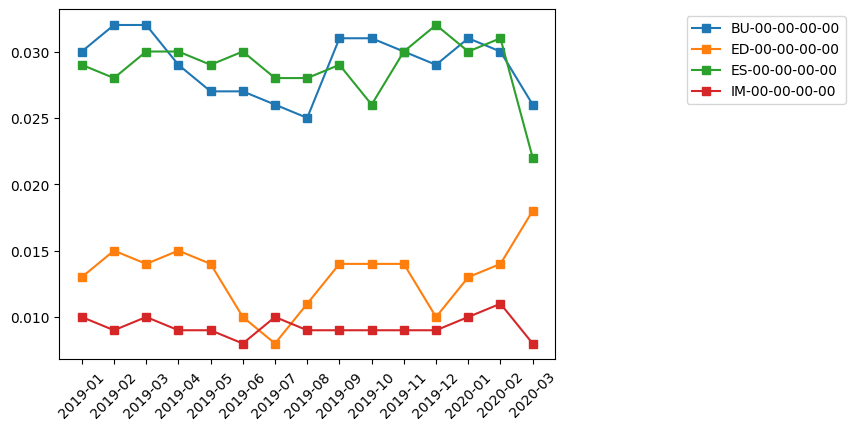

In [36]:
plot_prev_monthly('monthly_4.png', ["BU-00-00-00-00","ED-00-00-00-00","ES-00-00-00-00","IM-00-00-00-00"])

## Weekly Prevalence(2020-W1 ~ 04/02/2020)

In [37]:
import freq_e

def FREQ_E_WEEKLY(soft_dict, label_prior):
    bucket = defaultdict()
    freq_dict = defaultdict()
    
    for i in range(len(docs)):
        mt = docs[i]["week"]
        if mt in bucket.keys():
            bucket[mt].append(soft_dict[i])
        else:
            bucket[mt] = [soft_dict[i]]
            
    # We collect keys only in weekly_num_docs
    for k in weekly_num_docs.keys():
        test_pred_probs = np.asarray(bucket[k])
        out = freq_e.infer_freq_from_predictions(test_pred_probs, label_prior)
        freq_dict[k] = out["point"]

    return freq_dict

def plot_prev_weekly(filename, class_list):
    plt.gcf().subplots_adjust(bottom=0.15)
    for cls in tqdm(class_list[:7]):
        label_list = []
        loadListFile("prevs/" + cls[:5], label_list)
        hard_dict[cls] = label_list[0]
        soft_dict[cls] = label_list[1]
        #cc = CC(hard_dict[cls])
        result = FREQ_E_WEEKLY(soft_dict[cls], 0.5)
        plotDict(result, 45, "-s")
    lgd = plt.legend(class_list, bbox_to_anchor=(1.6, 1), loc='upper right', ncol=1)
    plt.savefig("figs/" + filename, bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.show()

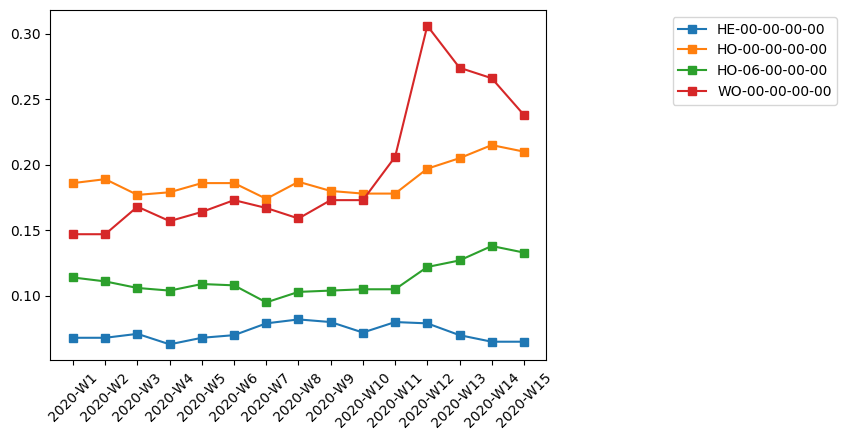

In [38]:
plot_prev_weekly('weekly_1.png', ["HE-00-00-00-00","HO-00-00-00-00","HO-06-00-00-00","WO-00-00-00-00"])

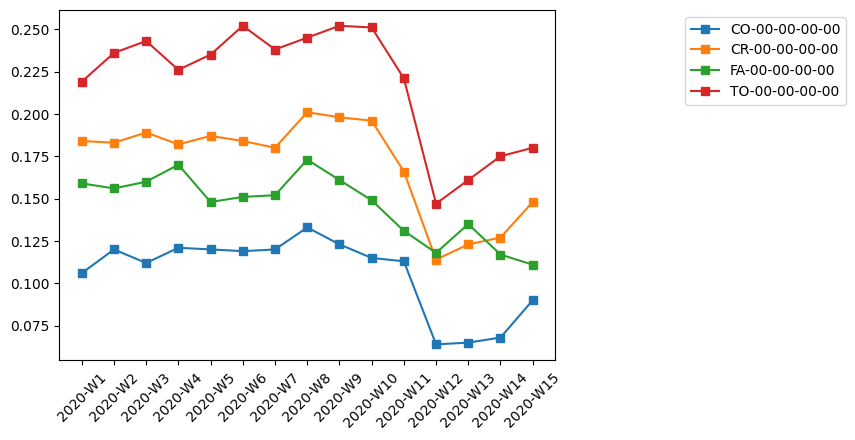

In [39]:
plot_prev_weekly("weekly_2.png", ["CO-00-00-00-00","CR-00-00-00-00","FA-00-00-00-00","TO-00-00-00-00"])

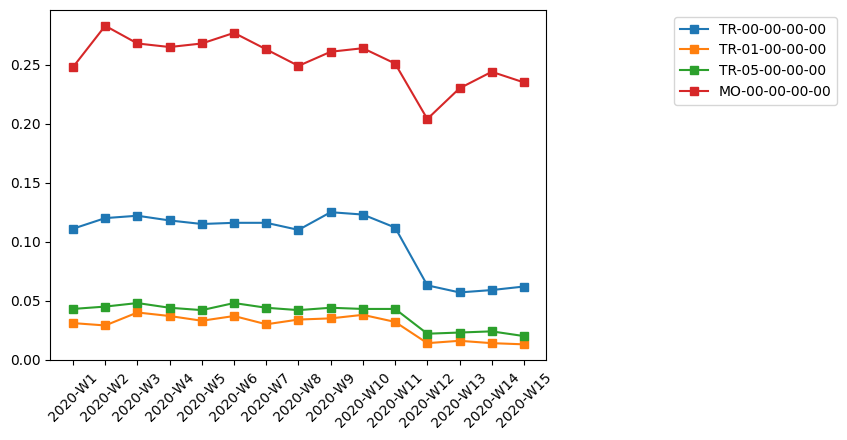

In [40]:
plot_prev_weekly('weekly_3.png', ["TR-00-00-00-00","TR-01-00-00-00","TR-05-00-00-00","MO-00-00-00-00"])

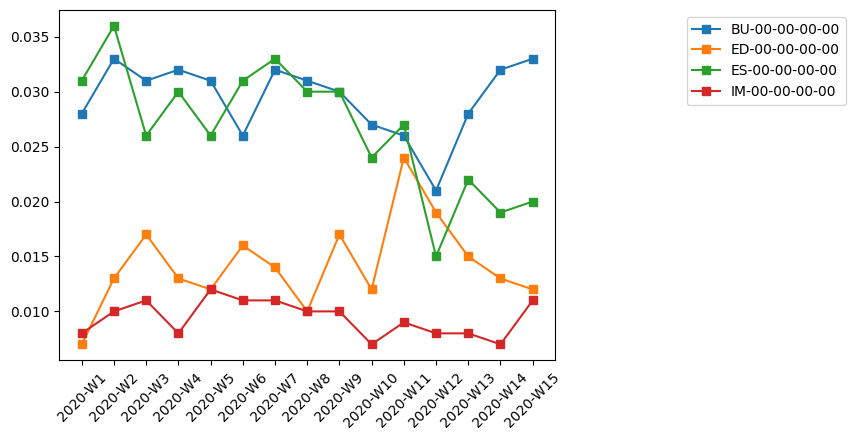

In [41]:
plot_prev_weekly('weekly_4.png', ["BU-00-00-00-00","ED-00-00-00-00","ES-00-00-00-00","IM-00-00-00-00"])

## Daily Prevalence(2020/3/1 - 2020/3/29)

In [42]:
import freq_e

def FREQ_E_DAILY(soft_dict, label_prior):
    bucket = defaultdict()
    freq_dict = defaultdict()
    
    for i in range(len(docs)):
        day = docs[i]["day"]
        if day in bucket.keys():
            bucket[day].append(soft_dict[i])
        else:
            bucket[day] = [soft_dict[i]]
            
    # We collect keys only in monthly_num_docs
    for k in daily_num_docs.keys():
        test_pred_probs = np.asarray(bucket[k])
        out = freq_e.infer_freq_from_predictions(test_pred_probs, label_prior)
        freq_dict[k] = out["point"]

    return freq_dict

In [43]:
import matplotlib.dates as mdates 


import matplotlib as mpl





def plot_prev_daily(filename, class_list):
    for cls in tqdm(class_list[:7]):
        label_list = []
        loadListFile("prevs/" + cls[:5], label_list)
        hard_dict[cls] = label_list[0]
        soft_dict[cls] = label_list[1]
        #cc = CC(hard_dict[cls])
        result = FREQ_E_DAILY(soft_dict[cls], 0.5)
        plotDict(result, 90, "-")
    lgd = plt.legend(class_list, bbox_to_anchor=(1.6, 1), loc='upper right', ncol=1)
    plt.savefig("figs/" + filename, bbox_extra_artists=(lgd,), bbox_inches='tight')

    plt.show()
    

    



HE-00: Health
HO-00: Housing
HO-06: Housing-Renting & Leasing
WO-00: Work and Employment Law


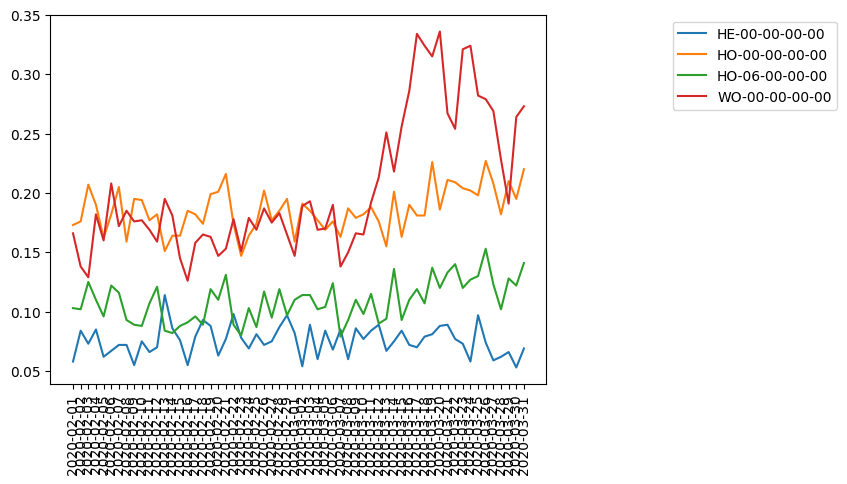

In [44]:
#for i in tqdm([0,1]):
#    plot_prev_monthly(class_list[4*i:4*i+4])
print("HE-00: Health")
print("HO-00: Housing")
print("HO-06: Housing-Renting & Leasing")
print("WO-00: Work and Employment Law")
plot_prev_daily('daily_1.png', ["HE-00-00-00-00","HO-00-00-00-00","HO-06-00-00-00","WO-00-00-00-00"])



CO-00: Courts and Lawyers
CR-00: Crime and Prisons
FA-00: Family
TO-00: Accidents and Torts


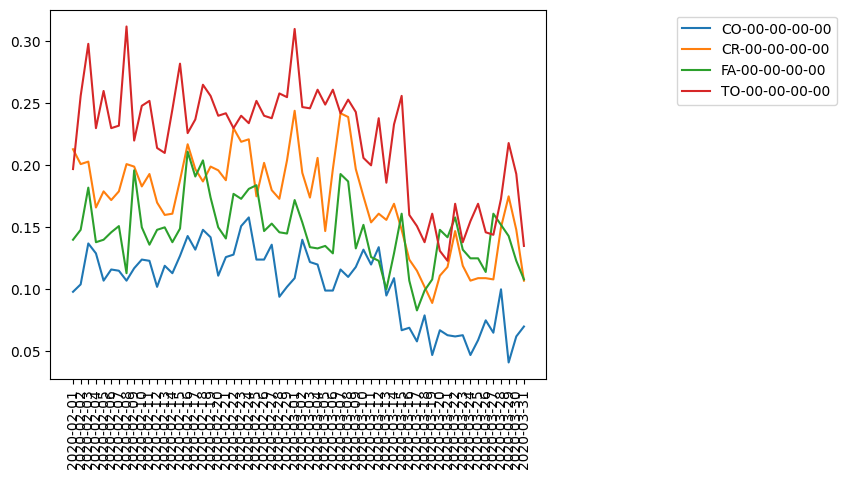

In [45]:
print("CO-00: Courts and Lawyers")
print("CR-00: Crime and Prisons")
print("FA-00: Family")
print("TO-00: Accidents and Torts")

plot_prev_daily("daily_2.png", ["CO-00-00-00-00","CR-00-00-00-00","FA-00-00-00-00","TO-00-00-00-00"])

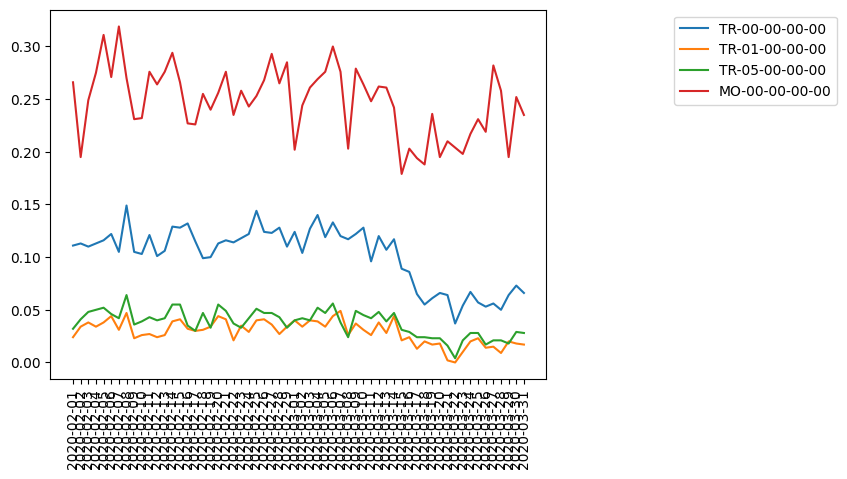

In [46]:
#for i in tqdm([2,3]):
#    plot_prev_monthly(class_list[4*i:4*i+4])
plot_prev_daily("daily_3.png", ["TR-00-00-00-00","TR-01-00-00-00","TR-05-00-00-00","MO-00-00-00-00"])


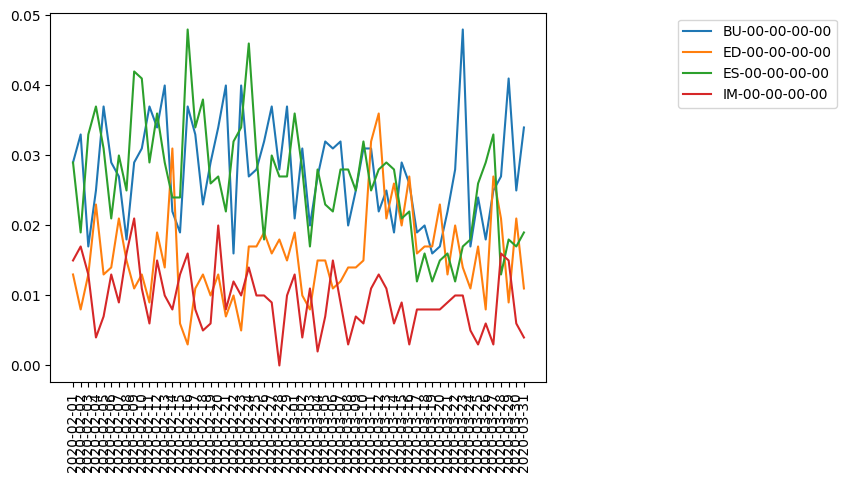

In [47]:
plot_prev_daily("daily_4.png", ["BU-00-00-00-00","ED-00-00-00-00","ES-00-00-00-00","IM-00-00-00-00"])